In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import random

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [6]:
data = np.genfromtxt('./data/clean_train.txt', delimiter=',', dtype=None)

/home/anton/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  """Entry point for launching an IPython kernel.


In [10]:
X = []
for sen in data:
    X.append(sen[0])

In [11]:
y = []
for sen in data:
    y.append(sen[1])

In [12]:
X[:10]

['slo gw damn on this special day of my life hahahahaaa',
 'this mjfans be really kind and friendly poke',
 'telah hadir junet junior entrepreneur technology we will do anything for you follow u',
 'ohhh yeah i think so hahah',
 'yeah good to get the rookie out today so proud of them actually they learn a lot and i will',
 'what for',
 'lol do you think we should dothat lol',
 'ameen rt ya allah bless my beloved cute girl everytime everywhere o',
 'thank we buy wine taste passport so the trip have already shift gear',
 'i believe that you should do a twit cam it would be awesomeee']

In [13]:
y = np.array(list(map(lambda x: 1 if x==1 else 0, y)))

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
all_word = []
for elem in X:
    for w in elem.split(' '):
        all_word.append(w)
all_word = list(set(all_word))

In [27]:
vocal_length = len(all_word) + 13

In [43]:
tokenizer = Tokenizer(num_words=vocal_length)
#tokenizer = Tokenizer(num_words=vocal_length, oov_token=1)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)

In [52]:
longest_tweet = max([len(x) for x in X_train])

In [54]:
X_train = pad_sequences(X_train, longest_tweet, padding='post')

In [55]:
X_train[1]

array([   8,  132,    4,   48,    3, 1773,  449, 3561,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0], dtype=int32)

In [84]:
"""from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('data/glove.twitter.27B.200d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()
"""

In [85]:
"""embedding_matrix = zeros((vocab_size, 200))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector"""

In [56]:
from keras.layers.recurrent import LSTM

model = Sequential()
embedding_layer = Embedding(vocal_length + 1, 200, input_length=longest_tweet)
model.add(embedding_layer)
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])


In [57]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 46, 200)           18500200  
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 18,668,777
Trainable params: 18,668,777
Non-trainable params: 0
_________________________________________________________________
None


In [58]:
history = model.fit(X_train, y_train, batch_size=64, epochs=3, verbose=1, validation_split=0.2)

/home/anton/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 116044 samples, validate on 29012 samples
Epoch 1/3
116044/116044 [==============================] - 572s 5ms/step - loss: 0.4901 - acc: 0.7529 - val_loss: 0.4338 - val_acc: 0.7945
Epoch 2/3
116044/116044 [==============================] - 579s 5ms/step - loss: 0.3724 - acc: 0.8314 - val_loss: 0.4256 - val_acc: 0.8022
Epoch 3/3
116044/116044 [==============================] - 590s 5ms/step - loss: 0.3002 - acc: 0.8702 - val_loss: 0.4533 - val_acc: 0.8005


In [82]:
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, longest_tweet, padding='post')

In [83]:
preds = []
for l in X_test:
    preds.append(model.predict(l.reshape(1,-1)))

In [84]:
preds = [1 if x > 0.5 else 0 for x in preds]

good = 0
for i in range(len(y_test)):
    if y_test[i] == preds[i]:
        good += 1
        
print("accuracy : " + str(good/len(preds)))

accuracy : 0.7956707569281677


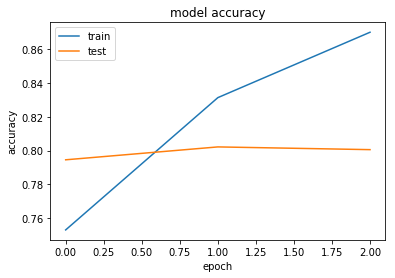

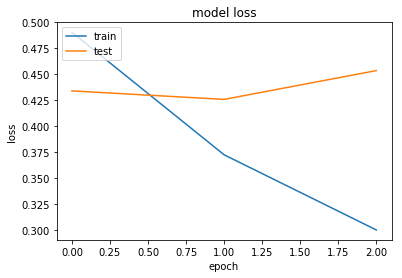

In [60]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Predict test data

In [85]:
def load_data(path, test=False):
    lines = []
    with open(path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        lines = [l.strip() for l in lines]
    if test:
        ids = [l.split(',')[0] for l in lines]
        return ids, lines
    else:
        return lines

In [90]:
test_data = load_data('./data/clean_test_data.txt')

In [87]:
test_data[:3]

['sea doo pro sea scooter sport with the portable seadoo seascootersave air stay longer in the water and',
 'shuck well i work all week so now i cant come cheer you on oh and put those battery in your calculator',
 'i cant stay away from bug thats my baby']

In [91]:
def predict(test_data):
    preds = []
    test_data = tokenizer.texts_to_sequences(test_data)
    test_data = pad_sequences(test_data, longest_tweet, padding='post')
    for l in test_data:
        preds.append(model.predict(l.reshape(1,-1)))
    return preds

In [92]:
preds = predict(test_data)

In [94]:
predictions = [1 if x > 0.5 else -1 for x in preds]

In [96]:
len(predictions)

10000

In [97]:
with open('out/prediction_1.csv', 'w') as f:
    f.write('Id,Prediction'+'\n')
    index = 1
    for p in predictions:
        f.write(str(index)+','+str(p)+'\n')
        index += 1